:Objective: The design and implementation of Generative Adversarial Networks (GANs) using PyTorch for MNIST digit synthesis.


# **Data** (and imports)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm


The next cell is from Copilot, I used it since I'm not familiar on how to import Mnist easely.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) #Used to transform the data of MNIST into tensors which can then be used by a GPU
train_mnist = datasets.MNIST(root ='./data',
                          train=True,
                          download=True,
                          transform=transform) # We then download the Train part of MNIST from datasets, and we apply the transformation ToTensors

100%|██████████| 9912422/9912422 [00:00<00:00, 118191722.44it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21270534.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47397687.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7313062.87it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
loader_train_mnist = DataLoader(train_mnist, shuffle = True, batch_size= 64) #We then use a Dataloader to create our batches. We use Shuffle = True since our data is not shuffled when we import it

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu" # We set the device to the GPU if it's avaible, it's using the CPU if not.


In [ ]:
device = 'cpu'

# **Step 1**: Basic GAN Implementation for MNIST Digit Synthesis

So a GAN is made of two main architectures : a Generator, and a Discriminator


*   **Generator**: The generator takes random noise as input and generates synthetic data that ideally becomes indistinguishable from real data.
*   **Discriminator**: The discriminator evaluates input data and attempts to distinguish between real and generated data.



## Generator

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define the model layers
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=output_dim)



        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

        # Define other layers
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh() #I was firstly using a Sigmoid, I had to go on internet in order to know that we had to use a Tanh

    def forward(self, x):
        # Forward pass using the same LeakyReLU instance
        h1 = self.fc1(x)
        z1 = self.leaky_relu(h1)
        z1 = self.dropout(z1)
        h2 = self.fc2(z1)
        z2 = self.leaky_relu(h2)
        z2 = self.dropout(z2)
        h3 = self.fc3(z2)
        out = self.tanh(h3)

        return out


## Discriminator

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define the model layers
        self.fc1 = nn.Linear(in_features=input_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=output_dim)



        # Use the same instance of LeakyReLU
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

        # Define other layers
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = x.view(x.shape[0], -1)#Flatten the image
        h1 = self.fc1(h0)
        z1 = self.leaky_relu(h1)
        z1 = self.dropout(z1)
        h2 = self.fc2(z1)
        z2 = self.leaky_relu(h2)
        z2 = self.dropout(z2)
        h3 = self.fc3(z2)
        out = self.sigmoid(h3)

        return out


## Training

In [ ]:
def train_gan(generator, discriminator, g_optimizer, d_optimizer, criterion ,dataloader, n_epochs):
  print('Training is starting')
  d_loss_list = [] #We use this to track the loss for a latter plot
  g_loss_list = [] #We use this to track the loss for a latter plot
  generator = generator.to(device)
  discriminator = discriminator.to(device)

  for epoch in trange(n_epochs):
    discriminator.train()
    generator.train()
    d_epoch_loss = 0
    g_epoch_loss = 0


    batch_iterator = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch}")
    for real_data, _ in batch_iterator:
      # We are using tahn so we need to rescale our data. We already know it's between 0 and 1 since we use ToTensor() in the dataloader
      real_im = real_data.to(device)
      real_im = (real_im * 2) - 1
      batch_size = len(real_im)

      #We are going to start by training the discriminator
      ## We are  first doing the discrimination of the real data.
      d_optimizer.zero_grad()

      output = discriminator(real_im)[:,0]
      real_labels = torch.ones(batch_size).to(device)
      d_real_loss = criterion(output, real_labels)

      ## Now we tackle the discriminator on fake images

      z = torch.randn((batch_size, hidden_dim)).to(device)
      fake_im = generator(z)
      #So now that those images are created we feed them to the discriminator
      output = discriminator(fake_im.detach())[:,0] # We do not forget to detach as we don't want the training to propagate into the generator layer here
      fake_labels = torch.zeros(batch_size).to(device)
      d_fake_loss = criterion(output,fake_labels)

      d_loss = d_fake_loss + d_real_loss

      d_loss.backward()
      d_optimizer.step()

      d_epoch_loss += d_loss

      # We are now going to tackle the generator

      g_optimizer.zero_grad()

      z = torch.randn((batch_size, hidden_dim)).to(device)

      fake_im = generator(z)
      output = discriminator(fake_im)[:,0]

      g_loss = criterion(output,real_labels)
      g_loss.backward()
      g_optimizer.step()

      g_epoch_loss += g_loss

      # Update the tqdm progress bar for each batch
      #batch_iterator.set_postfix(discriminator_loss=d_loss.item(), generator_loss=g_loss.item())

    d_loss_list.append(d_epoch_loss.item()/len(dataloader))
    g_loss_list.append(g_epoch_loss.item()/len(dataloader))


    tqdm.write(f"Epoch {epoch}; Discriminator: {d_loss_list[-1]:.3f}, Generator: {g_loss_list[-1]:.3f}")

  return g_loss_list, d_loss_list



Now that our train function is made, we can start to initiate both of the architectures and also the optimizers we are going to use.

In [ ]:
im_size = 784
hidden_dim = 100
discriminator = Discriminator(input_dim=im_size,output_dim=1)
generator = Generator(input_dim=hidden_dim,output_dim=im_size)

d_optimizer = torch.optim.Adam(discriminator.parameters(),lr = 0.001)
g_optimizer = torch.optim.Adam(generator.parameters(),lr = 0.001)

criterion = criterion = nn.BCELoss()


In [ ]:
g_losses, d_losses = train_gan(generator, discriminator, g_optimizer, d_optimizer,criterion,loader_train_mnist, 20)

Training is starting


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0; Discriminator: 0.996, Generator: 2.234


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1; Discriminator: 1.063, Generator: 2.171


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2; Discriminator: 0.973, Generator: 2.175


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3; Discriminator: 1.139, Generator: 1.763


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4; Discriminator: 1.148, Generator: 1.414


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5; Discriminator: 1.083, Generator: 1.448


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6; Discriminator: 1.118, Generator: 1.403


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7; Discriminator: 1.085, Generator: 1.435


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8; Discriminator: 1.130, Generator: 1.387


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9; Discriminator: 1.094, Generator: 1.379


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10; Discriminator: 1.167, Generator: 1.222


Epoch 11:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11; Discriminator: 1.109, Generator: 1.350


Epoch 12:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12; Discriminator: 1.092, Generator: 1.354


Epoch 13:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13; Discriminator: 1.103, Generator: 1.280


Epoch 14:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14; Discriminator: 1.156, Generator: 1.202


Epoch 15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15; Discriminator: 1.135, Generator: 1.240


Epoch 16:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16; Discriminator: 1.141, Generator: 1.201


Epoch 17:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17; Discriminator: 1.151, Generator: 1.185


Epoch 18:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18; Discriminator: 1.134, Generator: 1.218


Epoch 19:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19; Discriminator: 1.130, Generator: 1.217


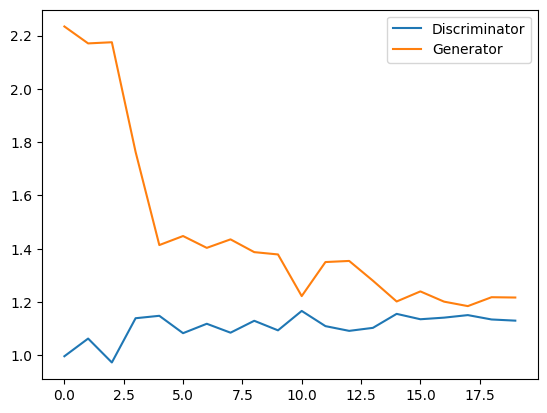

In [ ]:
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

## Generation !

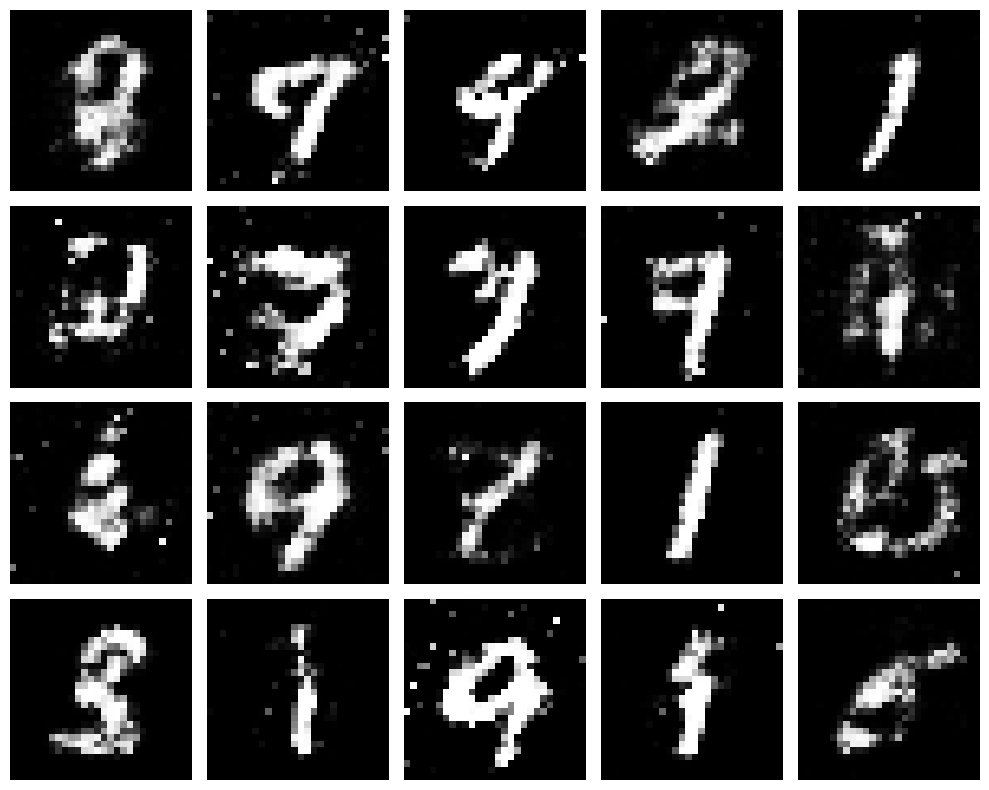

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming generator is your GAN generator
generator.eval()

# Number of generated images
num_images = 20

# Set up the subplot
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

# Generate and display 20 fake images
for i in range(num_images):
    # Generate a random latent vector
    z = np.random.randn(hidden_dim)
    z = torch.from_numpy(z).float().to(device)

    # Generate a fake image
    fake_image = generator(z)

    # Reshape the fake image
    fake_image = fake_image.view(28, 28).detach().cpu().numpy()

    # Display the fake image in the subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(fake_image, cmap='gray')
    ax.axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# **Step 2**: Conditional GAN Implementation

So we are going to change a bit our architecture to implement a conditional GAN

In [ ]:
#We ijnitialise the number of class that we are going to try to generate. Here for MNIST it's 10.
nb_classe = 10

## Generator

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        # Define the model layers
        self.fc1 = nn.Linear(in_features=input_dim + condition_dim, out_features=128) #Here we take in account the new input size
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=output_dim)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()

    def forward(self, x, condition):
        # Concatenate the noise vector with the conditional information

        x = torch.cat((x, condition), dim=1)

        # Forward pass using the same LeakyReLU instance
        h1 = self.fc1(x)
        z1 = self.leaky_relu(h1)
        z1 = self.dropout(z1)
        h2 = self.fc2(z1)
        z2 = self.leaky_relu(h2)
        z2 = self.dropout(z2)
        h3 = self.fc3(z2)
        out = self.tanh(h3)

        return out


## Discriminator

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        # Define the model layers
        self.fc1 = nn.Linear(in_features=input_dim + condition_dim, out_features=256) #Here we take in account the new input size
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=output_dim)

        # Use the same instance of LeakyReLU
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

        # Define other layers
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, condition):


        # Concatenate the input data with the conditional information
        x= x.view(x.shape[0], -1) #Flatten the image

        h0 = torch.cat((x, condition), dim=1)

        # Flatten the input tensor if it is not already flattened

        # Forward pass using the same LeakyReLU instance
        h1 = self.fc1(h0)
        z1 = self.leaky_relu(h1)
        z1 = self.dropout(z1)
        h2 = self.fc2(z1)
        z2 = self.leaky_relu(h2)
        z2 = self.dropout(z2)
        h3 = self.fc3(z2)
        out = self.sigmoid(h3)

        return out


## Training


In [ ]:
def train_conditional_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, n_epochs):
    print('Training is starting')
    d_loss_list = []  # We use this to track the loss for a later plot
    g_loss_list = []  # We use this to track the loss for a later plot
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    for epoch in trange(n_epochs):
        discriminator.train()
        generator.train()
        d_epoch_loss = 0
        g_epoch_loss = 0

        batch_iterator = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch}")
        for real_data, labels in batch_iterator:
            #We rescale our data
            real_im = real_data.to(device)
            real_im = (real_im * 2) - 1

            batch_size = len(real_im)
            labels = labels.to(device)

            # One-hot encode the labels (conditional information)
            labels_one_hot = torch.zeros(batch_size, nb_classe).to(device)
            labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)


            # Discriminator training
            d_optimizer.zero_grad()

            ## Training on real data
            output = discriminator(real_im, labels_one_hot)[:, 0] #We pass both the image and the labels to the discriminator
            real_labels = torch.ones(batch_size).to(device)
            d_real_loss = criterion(output, real_labels)

            ## Training on Fake data
            z = torch.randn((batch_size, hidden_dim)).to(device)
            fake_im = generator(z, labels_one_hot)
            output = discriminator(fake_im.detach(), labels_one_hot)[:, 0] # We do not forget to detach the tenssor as we don't want the discriminator training to propagate in the generator
            fake_labels = torch.zeros(batch_size).to(device)
            d_fake_loss = criterion(output, fake_labels)

            #We compute the total loss
            d_loss = d_fake_loss + d_real_loss

            d_loss.backward()
            d_optimizer.step()

            d_epoch_loss += d_loss

            # Generator training
            g_optimizer.zero_grad()

            z = torch.randn((batch_size, hidden_dim)).to(device)
            fake_im = generator(z, labels_one_hot)
            output = discriminator(fake_im, labels_one_hot)[:, 0]

            g_loss = criterion(output, real_labels)
            g_loss.backward()
            g_optimizer.step()

            g_epoch_loss += g_loss

        d_loss_list.append(d_epoch_loss.item() / len(dataloader))
        g_loss_list.append(g_epoch_loss.item() / len(dataloader))

        tqdm.write(f"Epoch {epoch}; Discriminator: {d_loss_list[-1]:.3f}, Generator: {g_loss_list[-1]:.3f}")

    return g_loss_list, d_loss_list


In [ ]:
im_size = 784
hidden_dim = 100
nb_classes = 10  # Number of classes for conditional GAN

# Instantiate the Discriminator and Generator with the required conditional information
discriminator = Discriminator(input_dim=im_size, output_dim=1,condition_dim=nb_classes)
generator = Generator(input_dim=hidden_dim, output_dim=im_size,condition_dim=nb_classes)

# Optimizers and Criterion
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Now train the conditional GAN using the adapted training loop

g_loss_list, d_loss_list = train_conditional_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, loader_train_mnist, 20)

Training is starting


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0; Discriminator: 0.931, Generator: 2.847


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1; Discriminator: 1.203, Generator: 1.961


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2; Discriminator: 1.278, Generator: 1.742


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3; Discriminator: 1.251, Generator: 1.806


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4; Discriminator: 1.064, Generator: 1.977


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5; Discriminator: 1.157, Generator: 1.601


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6; Discriminator: 1.123, Generator: 1.411


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7; Discriminator: 1.067, Generator: 1.504


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8; Discriminator: 1.052, Generator: 1.528


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9; Discriminator: 1.079, Generator: 1.455


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10; Discriminator: 1.088, Generator: 1.328


Epoch 11:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11; Discriminator: 1.044, Generator: 1.456


Epoch 12:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12; Discriminator: 1.097, Generator: 1.331


Epoch 13:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13; Discriminator: 1.126, Generator: 1.229


Epoch 14:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14; Discriminator: 1.100, Generator: 1.308


Epoch 15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15; Discriminator: 1.132, Generator: 1.208


Epoch 16:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16; Discriminator: 1.145, Generator: 1.182


Epoch 17:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17; Discriminator: 1.165, Generator: 1.138


Epoch 18:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18; Discriminator: 1.141, Generator: 1.177


Epoch 19:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19; Discriminator: 1.140, Generator: 1.187


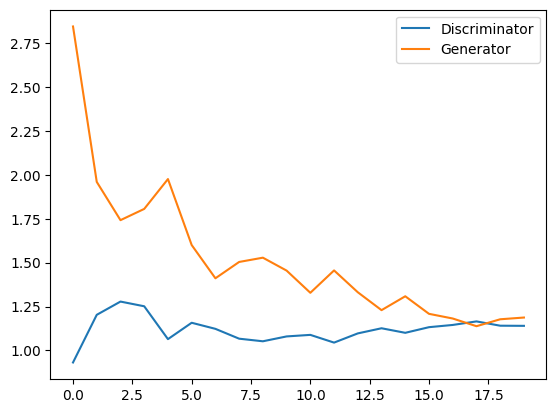

In [ ]:
plt.plot(d_loss_list, label='Discriminator')
plt.plot(g_loss_list, label='Generator')
plt.legend()
plt.show()

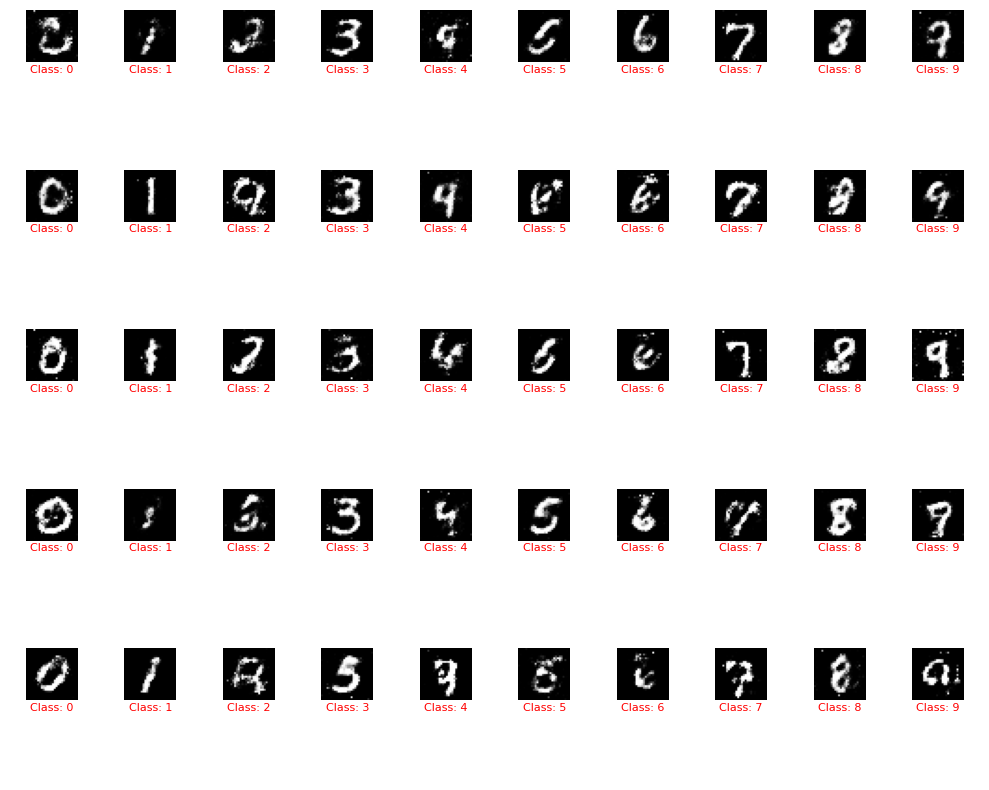

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming generator is your conditional GAN generator
generator.eval()

# Number of classes
num_classes = 10  # Update with the correct number of classes

# Number of generated images per class
num_images_per_class = 5

# Set up the subplot
fig, axes = plt.subplots(nrows=num_images_per_class * 2, ncols=nb_classes, figsize=(10, 8))

# Generate and display 5 fake images for each class
for class_index in range(nb_classes):
    for i in range(num_images_per_class):
        # Generate a random latent vector
        z = np.random.randn(1, hidden_dim)  # Add an extra dimension for batch size
        z = torch.from_numpy(z).float().to(device)

        # Create a one-hot encoded condition for the specific class
        condition = torch.zeros(1, nb_classes).to(device)
        condition[0, class_index] = 1  # One-hot encode the class

        # Generate a fake image for the specified class
        fake_image = generator(z, condition)

        # Reshape the fake image
        fake_image = fake_image.view(28, 28).detach().cpu().numpy()

        # Display the fake image in the subplot
        ax = axes[i * 2, class_index]
        ax.imshow(fake_image, cmap='gray')
        ax.axis('off')

        # Display the class index as a label under the image
        ax.text(0.5, -0.15, f'Class: {class_index}', transform=ax.transAxes,
                fontsize=8, ha='center', va='center', color='red')

        # Plot an empty space between rows
        ax = axes[i * 2 + 1, class_index]
        ax.axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# **Step 3**: Integrating an Encoder into the c-GAN


## Generator

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim, encoder_dim):
        super(Generator, self).__init__()

        # Encoder network inside the generator
        self.encoder = nn.Sequential(
            nn.Linear(in_features=output_dim, out_features=encoder_dim),
            nn.LeakyReLU(0.2),

        )

        # Generator network
        self.fc1 = nn.Linear(in_features=input_dim + encoder_dim + condition_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=output_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()

    def forward(self, noise, condition,real_im):
        # Encode real image into the latent space
        encoded_real_image = self.encoder(real_im.view(real_im.shape[0], -1))

        # Concatenate the noise vector, encoded real image, and conditional information
        x = torch.cat([noise, encoded_real_image, condition], dim=1)
        print(x.shape)
        # Forward pass through the generator network
        h1 = self.fc1(x)
        z1 = self.leaky_relu(h1)
        z1 = self.dropout(z1)
        h2 = self.fc2(z1)
        z2 = self.leaky_relu(h2)
        z2 = self.dropout(z2)
        h3 = self.fc3(z2)
        out = self.tanh(h3)

        return out


## Discriminator

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        # Define the model layers
        self.fc1 = nn.Linear(in_features=input_dim + condition_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=output_dim)

        # Use the same instance of LeakyReLU
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

        # Define other layers
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, condition):


        # Concatenate the input data with the conditional information
        x= x.view(x.shape[0], -1) # flatten the image

        h0 = torch.cat((x, condition), dim=1)

        # Flatten the input tensor if it is not already flattened

        # Forward pass using the same LeakyReLU instance
        h1 = self.fc1(h0)
        z1 = self.leaky_relu(h1)
        z1 = self.dropout(z1)
        h2 = self.fc2(z1)
        z2 = self.leaky_relu(h2)
        z2 = self.dropout(z2)
        h3 = self.fc3(z2)
        out = self.sigmoid(h3)

        return out


## Training

In [ ]:
def train_encoder_conditional_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, n_epochs):
    print('Training is starting')
    d_loss_list = []  # Track the discriminator loss for plotting
    g_loss_list = []  # Track the generator loss for plotting
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    for epoch in trange(n_epochs):
        discriminator.train()
        generator.train()
        d_epoch_loss = 0
        g_epoch_loss = 0

        batch_iterator = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch}")
        for real_data, labels in batch_iterator:
            real_im = real_data.to(device)
            real_im = (real_im * 2) - 1
            batch_size = len(real_im)
            labels = labels.to(device)

            # One-hot encode the labels (conditional information)
            labels_one_hot = torch.zeros(batch_size, nb_classes).to(device)
            labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

            # Generate a random noise vector
            z = torch.randn((batch_size, hidden_dim)).to(device)

            # Encode the real image into the latent space


            # Discriminator training
            d_optimizer.zero_grad()

            output_real = discriminator(real_im, labels_one_hot)[:, 0]
            real_labels = torch.ones(batch_size).to(device)
            d_real_loss = criterion(output_real, real_labels)

            fake_im = generator(z, labels_one_hot,real_im)
            output_fake = discriminator(fake_im.detach(), labels_one_hot)[:, 0]
            fake_labels = torch.zeros(batch_size).to(device)
            d_fake_loss = criterion(output_fake, fake_labels)

            # Update the discriminator
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            d_epoch_loss += d_loss.item()

            # Generator training
            g_optimizer.zero_grad()

            # Generate a new fake image and get the discriminator's response
            fake_im = generator(z, labels_one_hot,real_im)
            output_fake = discriminator(fake_im, labels_one_hot)[:, 0]

            # Update the generator
            g_loss = criterion(output_fake, real_labels)
            g_loss.backward()
            g_optimizer.step()

            # Print or log the losses if needed

            # Update the encoder during the training (this doesn't work do i don't really know how to do)
            '''encoded_real_image = generator.encoder(real_im.view(real_im.shape[0], -1))
            encoded_fake_image = generator.encoder(fake_im.view(real_im.shape[0], -1))
            encoder_loss = criterion(encoded_fake_image, encoded_real_image.detach())
            encoder_loss.backward()'''

            g_epoch_loss += g_loss.item()

        d_loss_list.append(d_epoch_loss / len(dataloader))
        g_loss_list.append(g_epoch_loss / len(dataloader))

        tqdm.write(f"Epoch {epoch}; Discriminator: {d_loss_list[-1]:.3f}, Generator: {g_loss_list[-1]:.3f}")

    return g_loss_list, d_loss_list


In [ ]:
im_size = 784
hidden_dim = 100
nb_classes = 10  # Number of classes for conditional GAN
encoder_dim = 100


# Instantiate the Discriminator and Generator with the required conditional information
discriminator = Discriminator(input_dim=im_size, output_dim=1, condition_dim=nb_classes)
generator = Generator(input_dim=hidden_dim, output_dim=im_size, condition_dim=nb_classes, encoder_dim=encoder_dim)

# Optimizers and Criterion
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Now train the Encoder-Conditional GAN using the adapted training loop
g_loss_list, d_loss_list = train_encoder_conditional_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, loader_train_mnist, 20)


Training is starting


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size([64, 784])
torch.Size([64, 210])
torch.Size([64, 210])
torch.Size

KeyboardInterrupt: ignored